In [1]:
import torch
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} directory exist , skipping...")
else:
    print("start downloading...")
    image_path.mkdir(parents=True, exist_ok=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("unzipping...")
        zip_ref.extractall(image_path)

    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exist , skipping...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Manual

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize  
])

In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,test_dir, manual_transform, 32, 0)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2ade1723e50>,
 ['pizza', 'steak', 'sushi'])

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, auto_transforms, 32, 0)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2ade172e8d0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# old method in 0.13
torch.hub.set_dir("data")
# model = torchvision.models.efficientnet_b0(pretrained=True)
# 
# new in 0.15
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [13]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
# print summary
from torchinfo import summary

summary(model=model, input_size=(1,3,224,224), # example of [batch_size, color_chanel, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [16]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [17]:
# frees the base model and update the output layers:
for param in model.features.parameters():
    param.requires_grad = False
    # print(param)

In [18]:
# update the classifier
from torch import nn

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(model=model, input_size=(1,3,224,224), # example of [batch_size, color_chanel, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train Model

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [24]:
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 20

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

end_time = timer()
print(end_time-start_time)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5220 | train_acc: 0.9297 | test_loss: 0.5827 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.4755 | train_acc: 0.9453 | test_loss: 0.5300 | test_acc: 0.9167
Epoch: 3 | train_loss: 0.4528 | train_acc: 0.9336 | test_loss: 0.5239 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.4778 | train_acc: 0.8438 | test_loss: 0.4811 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.4061 | train_acc: 0.9570 | test_loss: 0.5008 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4256 | train_acc: 0.9453 | test_loss: 0.4782 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.3948 | train_acc: 0.9531 | test_loss: 0.4621 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.4189 | train_acc: 0.8242 | test_loss: 0.4580 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.4733 | train_acc: 0.8125 | test_loss: 0.4391 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4106 | train_acc: 0.8398 | test_loss: 0.3919 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3471 | train_acc: 0.9688 | test_loss: 0.4147 | test_acc: 0.8759
Epoch: 12 | train_l

In [25]:
try:
    import helper_functions
except:
    print("failed")

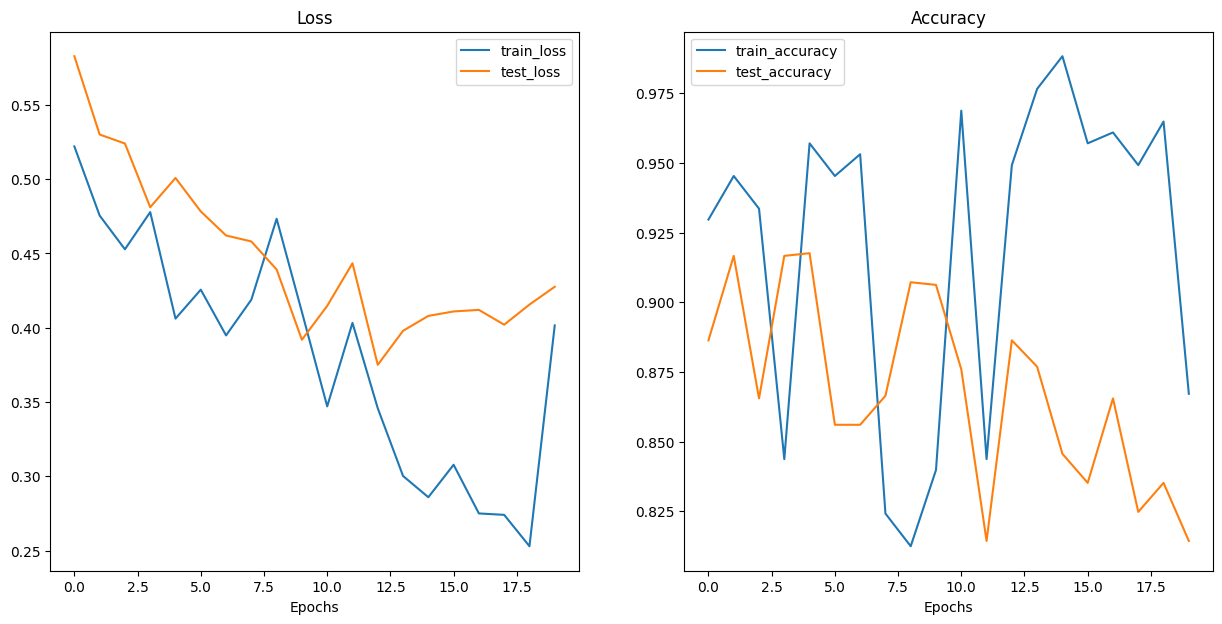

In [26]:
helper_functions.plot_loss_curves(results)